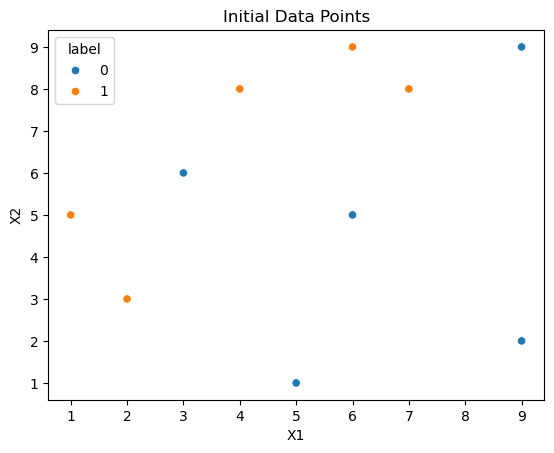

   X1  X2  label  weights
0   1   5      1      0.1
1   2   3      1      0.1
2   3   6      0      0.1
3   4   8      1      0.1
4   5   1      0      0.1
5   6   9      1      0.1
6   6   5      0      0.1
7   7   8      1      0.1
8   9   9      0      0.1
9   9   2      0      0.1


In [57]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Step 1: Create data
df = pd.DataFrame({
    'X1': [1,2,3,4,5,6,6,7,9,9],
    'X2': [5,3,6,8,1,9,5,8,9,2],
    'label': [1,1,0,1,0,1,0,1,0,0]
})

sns.scatterplot(x='X1', y='X2', hue='label', data=df)
plt.title("Initial Data Points")
plt.show()
df['weights']=1/df.shape[0]
print(df)

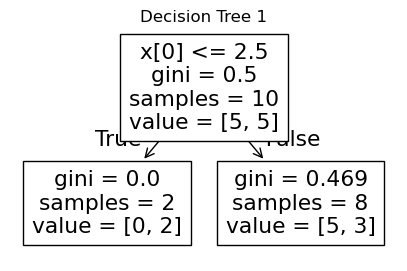

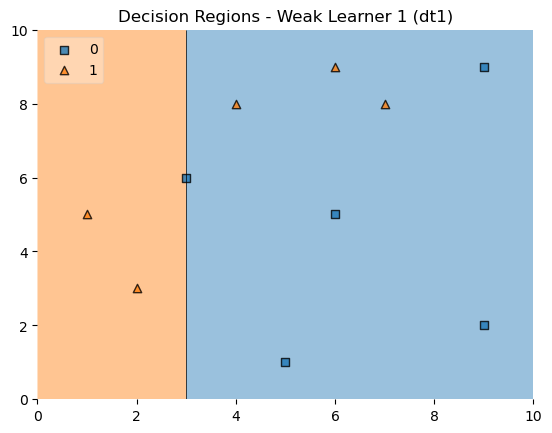

In [58]:
# Step 2: First weak learner (dt1)
x = df[['X1', 'X2']].values
y = df['label'].values

dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(x, y)

df['y_pred'] = dt1.predict(x)


plt.figure(figsize=(5, 3))
plot_tree(dt1)
plt.title("Decision Tree 1")
plt.show()

plot_decision_regions(x, y, clf=dt1, legend=2)
plt.title("Decision Regions - Weak Learner 1 (dt1)")
plt.show()

In [59]:
# Step 3: Calculate alpha1
def calculate_model_weight(error, epsilon=1e-10):
    error = np.clip(error, epsilon, 1 - epsilon)
    return 0.5 * np.log((1 - error) / error)

alpha1 = calculate_model_weight(0.3)
print(f"Alpha1 = {alpha1:.3f}")


Alpha1 = 0.424


In [60]:
# Step 4: Update sample weights
df['weights'] = 1 / df.shape[0]

def update_row_weights(row, alpha=alpha1):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    else:
        return row['weights'] * np.exp(alpha)

df['updated_weights'] = df.apply(update_row_weights, axis=1)
df['normalized_weights'] = df['updated_weights'] / df['updated_weights'].sum()
df['cumsum_upper'] = np.cumsum(df['normalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalized_weights']

print("\n After First Model:")
print(df[['X1', 'X2', 'label', 'y_pred', 'weights', 'normalized_weights']])



 After First Model:
   X1  X2  label  y_pred  weights  normalized_weights
0   1   5      1       1      0.1            0.071429
1   2   3      1       1      0.1            0.071429
2   3   6      0       0      0.1            0.071429
3   4   8      1       0      0.1            0.166667
4   5   1      0       0      0.1            0.071429
5   6   9      1       0      0.1            0.166667
6   6   5      0       0      0.1            0.071429
7   7   8      1       0      0.1            0.166667
8   9   9      0       0      0.1            0.071429
9   9   2      0       0      0.1            0.071429


In [61]:
# Step 5: Resample based on weights
def create_new_dataset(df):
    indices = []
    for _ in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and a > row['cumsum_lower']:
                indices.append(index)
                break
    return indices

index_values = create_new_dataset(df)
second_df = df.iloc[index_values, [0, 1, 2, 3]].reset_index(drop=True)
print("\n Resampled Dataset for 2nd Model:")
print(second_df)



 Resampled Dataset for 2nd Model:
   X1  X2  label  weights
0   6   5      0      0.1
1   5   1      0      0.1
2   6   5      0      0.1
3   4   8      1      0.1
4   9   9      0      0.1
5   1   5      1      0.1
6   6   5      0      0.1
7   1   5      1      0.1
8   4   8      1      0.1
9   9   9      0      0.1


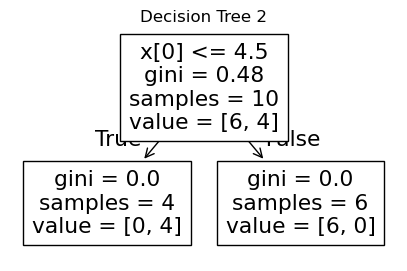

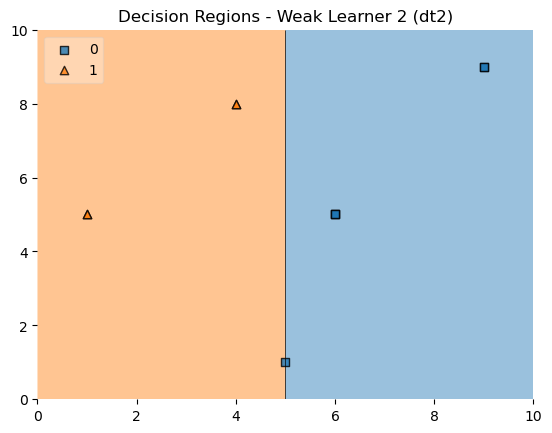


Alpha2 = 1.099


In [62]:
# Step 6: Train second weak learner (dt2)
x2 = second_df[['X1', 'X2']].values
y2 = second_df['label'].values

dt2 = DecisionTreeClassifier(max_depth=1)
dt2.fit(x2, y2)
second_df['y_pred'] = dt2.predict(x2)

plt.figure(figsize=(5, 3))
plot_tree(dt2)
plt.title("Decision Tree 2")
plt.show()

plot_decision_regions(x2, y2, clf=dt2, legend=2)
plt.title("Decision Regions - Weak Learner 2 (dt2)")
plt.show()

alpha2 = calculate_model_weight(0.1)
print(f"\nAlpha2 = {alpha2:.3f}")


In [63]:
# Step 7: Update weights again
second_df['weights'] = 1 / second_df.shape[0]

def update_row_weights2(row, alpha=alpha2):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    else:
        return row['weights'] * np.exp(alpha)

second_df['updated_weights'] = second_df.apply(update_row_weights2, axis=1)
second_df['normalized_weights'] = second_df['updated_weights'] / second_df['updated_weights'].sum()
second_df['cumsum_upper'] = np.cumsum(second_df['normalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalized_weights']

print("\n After Second Model:")
print(second_df[['X1', 'X2', 'label', 'y_pred', 'weights', 'normalized_weights']])



 After Second Model:
   X1  X2  label  y_pred  weights  normalized_weights
0   6   5      0       0      0.1                 0.1
1   5   1      0       0      0.1                 0.1
2   6   5      0       0      0.1                 0.1
3   4   8      1       1      0.1                 0.1
4   9   9      0       0      0.1                 0.1
5   1   5      1       1      0.1                 0.1
6   6   5      0       0      0.1                 0.1
7   1   5      1       1      0.1                 0.1
8   4   8      1       1      0.1                 0.1
9   9   9      0       0      0.1                 0.1



 Resampled Dataset for 3rd Model:
   X1  X2  label  weights
0   4   8      1      0.1
1   9   9      0      0.1
2   1   5      1      0.1
3   6   5      0      0.1
4   4   8      1      0.1
5   9   9      0      0.1
6   6   5      0      0.1
7   6   5      0      0.1
8   9   9      0      0.1
9   6   5      0      0.1


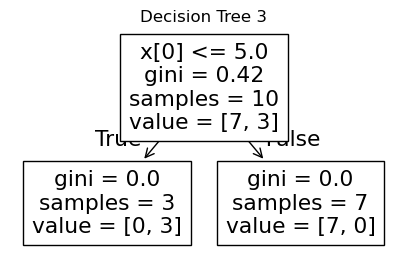

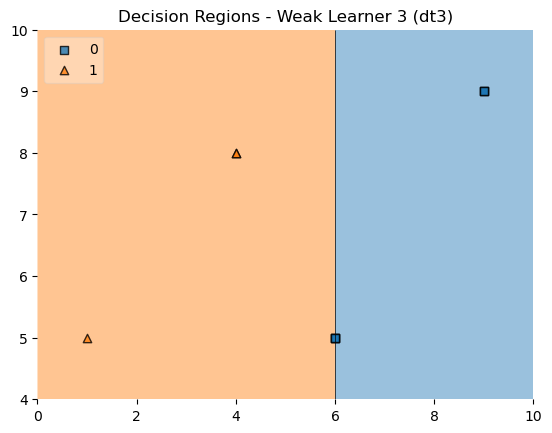


Alpha3 = -0.424


In [64]:
# Step 8: Train third weak learner (dt3)
index_values2 = create_new_dataset(second_df)
third_df = second_df.iloc[index_values2, [0, 1, 2, 3]].reset_index(drop=True)
print("\n Resampled Dataset for 3rd Model:")
print(third_df)

x3 = third_df[['X1', 'X2']].values
y3 = third_df['label'].values

dt3 = DecisionTreeClassifier(max_depth=1)
dt3.fit(x3, y3)
third_df['y_pred'] = dt3.predict(x3)

plt.figure(figsize=(5, 3))
plot_tree(dt3)
plt.title("Decision Tree 3")
plt.show()


plot_decision_regions(x3, y3, clf=dt3, legend=2)
plt.title("Decision Regions - Weak Learner 3 (dt3)")
plt.show()

alpha3 = calculate_model_weight(0.7)
print(f"\nAlpha3 = {alpha3:.3f}")

In [65]:
# Step 9: Final AdaBoost-style prediction
print("\n Model Weights (alphas):", alpha1, alpha2, alpha3)

# Example Query 1
query1 = np.array([1, 5]).reshape(1, 2)
print("\nQuery [1,5]:")
print("dt1:", dt1.predict(query1))
print("dt2:", dt2.predict(query1))
print("dt3:", dt3.predict(query1))

vote = alpha1 * (1 if dt1.predict(query1)==1 else -1) + \
       alpha2 * (1 if dt2.predict(query1)==1 else -1) + \
       alpha3 * (1 if dt3.predict(query1)==1 else -1)
print("Final Ensemble Output:", np.sign(vote))

# Example Query 2
query2 = np.array([9, 9]).reshape(1, 2)
print("\nQuery [9,9]:")
print("dt1:", dt1.predict(query2))
print("dt2:", dt2.predict(query2))
print("dt3:", dt3.predict(query2))

vote = alpha1 * (1 if dt1.predict(query2)==1 else -1) + \
       alpha2 * (1 if dt2.predict(query2)==1 else -1) + \
       alpha3 * (1 if dt3.predict(query2)==1 else -1)
print("Final Ensemble Output:", np.sign(vote))



 Model Weights (alphas): 0.42364893019360184 1.0986122886681098 -0.4236489301936017

Query [1,5]:
dt1: [1]
dt2: [1]
dt3: [1]
Final Ensemble Output: 1.0

Query [9,9]:
dt1: [0]
dt2: [0]
dt3: [0]
Final Ensemble Output: -1.0
